# Constraining a Dark Matter Halo with JAM and AdaMet

[<img src="https://users.physics.ox.ac.uk/~cappellari/images/jam-logo.svg" width="100">](https://users.physics.ox.ac.uk/~cappellari/software/#sec:jam)

This notebook demonstrates how to constrain the dark matter halo of a galaxy using Jeans Anisotropic Modelling (JAM).
The analysis uses the JAM method ([Cappellari 2008](https://ui.adsabs.harvard.edu/abs/2008MNRAS.390...71C/abstract), [Cappellari 2020](https://ui.adsabs.harvard.edu/abs/2020MNRAS.494.4819C/abstract)) as implemented in the [`jampy`](https://pypi.org/project/jampy/) package.
The Bayesian inference is performed with the AdaMet MCMC sampler ([Cappellari et al. 2013](https://ui.adsabs.harvard.edu/abs/2013MNRAS.432.1709C/abstract)) from the [`adamet`](https://pypi.org/project/adamet/) package.

- **V1.0.0**: Written. Michele Cappellari, Oxford, 3 October 2022
- **V1.1.0**: Expanded documentation and converted to jupytext format. MC, Oxford, 21 July 2025

## 1. Imports

We begin by importing the necessary libraries. This includes standard data science packages (`numpy`, `matplotlib`) and specialized astronomy libraries essential for this analysis:

- `plotbin`: Used for visualizing the 2D binned kinematic data (e.g., from an Integral Field Unit).
- `jampy`: The core package for performing Jeans Anisotropic Modelling. It solves the Jeans equations to predict the stellar kinematics for a given mass model.
- `mgefit`: A package for fitting Multi-Gaussian Expansion (MGE) models to photometric or density profiles. MGEs provide an efficient way to represent the galaxy's stellar and dark matter components.
- `adamet`: An adaptive MCMC sampler used to efficiently explore the multi-dimensional parameter space of our model.

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# All packages below are available at https://pypi.org/user/micappe/
from plotbin.plot_velfield import plot_velfield
from plotbin.symmetrize_velfield import symmetrize_velfield

import jampy as jam
import mgefit as mge
import capfit

from adamet.adamet import adamet
from adamet.corner_plot import corner_plot

## 2. Model Components

We define two helper functions to construct the total mass model of the galaxy, which is composed of a stellar component and a dark matter halo.

### Dark Halo MGE

The `dark_halo_mge` function creates an MGE representation of a generalized Navarro-Frenk-White (gNFW) dark halo profile. The gNFW profile is a widely used model for dark matter halos, characterized by an inner logarithmic slope (`gamma`) and a break radius (`rbreak`). For a standard NFW profile, `gamma` = -1. Representing the halo density with an MGE is computationally advantageous as it allows for fast and analytic solutions of the gravitational potential and the Jeans equations.

In [2]:
def dark_halo_mge(gamma, rbreak):
    """
    Returns the MGE parameters for a generalized NFW dark halo profile
    https://ui.adsabs.harvard.edu/abs/2001ApJ...555..504W
    - gamma is the inner logarithmic slope (gamma = -1 for NFW)
    - rbreak is the break radius in arcsec

    """
    # The fit is performed in log spaced radii from 1" to 10*rbreak
    n = 300     # Number of values to sample the gNFW profile for the MGE fit
    r = np.geomspace(1, rbreak*10, n)   # logarithmically spaced radii in arcsec
    rho = (r/rbreak)**gamma * (0.5 + 0.5*r/rbreak)**(-gamma - 3)  # rho=1 at r=rbreak
    m = mge.fit_1d(r, rho, ngauss=15, quiet=1, plot=0)

    surf_dm, sigma_dm = m.sol           # Peak surface density and sigma
    qobs_dm = np.ones_like(surf_dm)     # Assume spherical dark halo

    return surf_dm, sigma_dm, qobs_dm

### Total Mass MGE

The `total_mass_mge` function combines the MGE for the stellar component (light) with the MGE for the dark halo. A key parameter in this combination is the dark matter fraction (`f_dm`) within the galaxy's effective radius (`reff`). By scaling the dark halo component to match a given `f_dm`, we can make this physically intuitive quantity a direct fitting parameter in our MCMC analysis. This is often more stable and interpretable than fitting for, e.g., the total halo mass, which is usually poorly constrained.

In [3]:
def total_mass_mge(surf_lum, sigma_lum, qobs_lum, gamma, rbreak, f_dm, inc):
    """
    Combine the MGE from a dark halo and the MGE from the stellar surface
    brightness in such a way to have a given dark matter fractions f_dm
    inside a sphere of radius one half-light radius reff

    """
    surf_dm, sigma_dm, qobs_dm = dark_halo_mge(gamma, rbreak)

    reff = jam.mge.half_light_radius(surf_lum, sigma_lum, qobs_lum)[0]
    stars_lum_re = jam.mge.radial_mass(surf_lum, sigma_lum, qobs_lum, inc, reff)
    dark_mass_re = jam.mge.radial_mass(surf_dm, sigma_dm, qobs_dm, inc, reff)

    # Find the scale factor needed to satisfy the following definition
    # f_dm == dark_mass_re*scale/(stars_lum_re + dark_mass_re*scale)
    scale = (f_dm*stars_lum_re)/(dark_mass_re*(1 - f_dm))

    surf_pot = np.append(surf_lum, surf_dm*scale)   # Msun/pc**2. DM scaled so that f_DM(Re)=f_DM
    sigma_pot = np.append(sigma_lum, sigma_dm)      # Gaussian dispersion in arcsec
    qobs_pot = np.append(qobs_lum, qobs_dm)

    return surf_pot, sigma_pot, qobs_pot

## 3. MGE Model and Kinematic Data

### MGE Model
The MGE parameters used here describe the nearby galaxy M32 and are taken from Table B1 of [Cappellari et al. (2006)](http://adsabs.harvard.edu/abs/2006MNRAS.366.1126C).

In [4]:
# MGE model of the galaxy M32 from Table B1 of Cappellari et al. (2006)
# http://adsabs.harvard.edu/abs/2006MNRAS.366.1126C
surf_lum = 10**np.array([6.187, 5.774, 5.766, 5.613, 5.311, 4.774, 4.359, 4.087, 3.682, 3.316, 2.744, 1.618])
sigma_lum = 10**np.array([-1.762, -1.143, -0.839, -0.438, -0.104, 0.232, 0.560, 0.835, 1.160, 1.414, 1.703, 2.249])
qobs_lum = np.array([0.790, 0.741, 0.786, 0.757, 0.720, 0.724, 0.725, 0.743, 0.751, 0.838, 0.835, 0.720])

### Mock Kinematics
We load mock kinematic data. Using simulated data is a critical validation step in dynamical modeling. It allows us to test whether our entire analysis pipeline can accurately recover the known input parameters of the simulation before applying it to real observational data where the ground truth is unknown.

In [5]:
# Read mock kinematics with realistic parameters and noise
jam_dir = Path(jam.__file__).parent
filename = jam_dir / 'examples/jam_mock_kinematics_dark_halo.txt'
xbin, ybin, rms, erms, flux = np.loadtxt(filename).T
distance = 0.7   # M32 Distance

### Accounting for Systematic Errors
In real observations, the uncertainties on kinematic measurements are often underestimated because they do not account for systematic effects (e.g., template mismatch, imperfect sky subtraction). Failing to account for these can lead to an overly confident (i.e., too small) estimation of the parameter uncertainties. The following line applies a simple but effective recipe to inflate the formal errors to account for such systematics, as discussed in Mitzkus et al. (2017).

In [6]:
# The following line tries to *approximately* account for systematic errors.
# See beginning of Sec.6.1 of Mitzkus+17 for an explanation
# https://ui.adsabs.harvard.edu/abs/2017MNRAS.464.4789M
erms *= (2*rms.size)**0.25

## 4. Model Setup

### Starting Guesses and Priors

We provide initial guesses for the parameters to be fitted and define the prior bounds for the MCMC sampler. In a Bayesian context, the priors define the range of plausible values for each parameter before considering the data. We use uniform (flat) priors, which assign equal probability to all values within the specified `bounds`.

The free parameters in our model are:
- `q0`: The intrinsic axial ratio of the galaxy, describing its 3D shape.
- `ratio0`: The velocity anisotropy ratio (σz/σR), which quantifies the shape of the stellar velocity ellipsoid.
- `f_dm0`: The dark matter fraction within one effective radius.
- `lg_ml0`: The base-10 logarithm of the stellar mass-to-light ratio (M/L).

Note that some halo parameters (`gamma`, `rbreak`) are kept fixed. These are often difficult to constrain without very spatially extended kinematic data.
prova
> **Important:**  
> I use the axial ratio $q$ of the flattest MGE Gaussian to parametrize the inclination angle. This is the recommended approach in JAM because galaxy kinematics vary smoothly as a function of $q$, but not as a function of inclination. Parametrizing models by inclination can result in very inefficient sampling of the model posterior.

In [12]:
# Starting guess, e.g. from a previous least-squares fit
q0 = 0.55               # Axial ratio of the flattest MGE Gaussian
ratio0 = 0.9            # Anisotropy ratio sigma_z/sigma_R
f_dm0 = 0.15            # Dark matter fraction inside a sphere of radius Re
lg_ml0 = np.log10(1.4)  # I sample the M/L logarithmically

pixsize = 2             # spaxel size in arcsec (before Voronoi binning)
sigmapsf = 4/2.355      # sigma PSF in arcsec (=FWHM/2.355)
normpsf = 1

# I adjusted the fitting range below after an initial fit which
# gave me an idea of some suitable ranges for the parameters
qmin = np.min(qobs_lum)
p0 =      [q0,    ratio0, f_dm0, lg_ml0]
bounds = [[0.051, 0.5,    0,     lg_ml0-0.2], 
          [qmin,  1,      0.5,   lg_ml0+0.2]]
labels = [r"$q_{\rm min}$", r"$\sigma_z/\sigma_R$", r"$f_{\rm DM}(R_{\rm e})$", r"$\lg(M_\ast/L)$"]

goodbins = np.isfinite(xbin)  # Here I fit all bins

## 5. Bayesian Inference

### Define Log-Probability Function
The `jam_lnprob` function calculates the log-posterior probability. According to Bayes' theorem,

$$
P(\theta\,|\,\mathrm{data}) \propto P(\mathrm{data}\,|\,\theta)\,P(\theta)
$$

where $\theta$ are the model parameters. In log space,

$$
\log P(\theta\,|\,\mathrm{data}) = \log P(\mathrm{data}\,|\,\theta) + \log P(\theta)
$$

For flat priors, $\log P(\theta)$ is constant within the bounds, so only the log-likelihood needs to be computed. Assuming Gaussian errors, the log-likelihood is

$$
\log P(\mathrm{data}\,|\,\theta) = -\frac{1}{2}\chi^2
$$

For a given set of parameters, this function:
1. Constructs the total mass model (stars + dark halo).
2. Calls `jam.axi.proj` to solve the Jeans equations and predict the second velocity moment ($V_{\mathrm{rms}}$).
3. Calculates $\chi^2$ by comparing the model prediction to the data.
4. Returns $-\frac{1}{2}\chi^2$ as the log-likelihood.

In [8]:
def jam_lnprob(pars):
    """
    Return the probability of the model, given the data, assuming constant priors

    """
    q, ratio, f_dm, lg_ml = pars

    # Sample inclination using min(q), with Equation (14) of Cappellari (2008)
    qmin = np.min(qobs_lum)
    inc = np.degrees(np.arctan2(np.sqrt(1 - qmin**2), np.sqrt(qmin**2 - q**2)))
    beta = np.full_like(qobs_lum, 1 - ratio**2)   # assume constant anisotropy

    # In this example I keep the halo slope and break radius fixed.
    # These parameters could be fitted from good and spatially-extended data.
    gamma = -1                  # Adopt fixed NFW inner halos slope
    rbreak = 20e3               # Adopt fixed halo break radius of 20 kpc (much larger than the data)
    pc = distance*np.pi/0.648   # Constant factor to convert arcsec --> pc
    rbreak /= pc                # Convert the break radius from pc --> arcsec
    mbh = 0                     # Ignore the central black hole
    surf_pot, sigma_pot, qobs_pot = total_mass_mge(surf_lum, sigma_lum, qobs_lum, gamma, rbreak, f_dm, inc)

    # Note: I multiply surf_pot by ml=10**lg_ml, while I set the keyword ml=1
    # Both the stellar and dark matter increase by ml and f_dm is unchanged
    surf_pot *= 10**lg_ml
    out = jam.axi.proj(surf_lum, sigma_lum, qobs_lum, surf_pot, sigma_pot, qobs_pot,
                    inc, mbh, distance, xbin, ybin, plot=False, pixsize=pixsize, quiet=1,
                    sigmapsf=sigmapsf, normpsf=normpsf, goodbins=goodbins, align='cyl',
                    beta=beta, data=rms, errors=erms, ml=1)

    jam_lnprob.out = out   # Store output for plotting

    resid = (rms[goodbins] - out.model[goodbins])/erms[goodbins]
    chi2 = resid @ resid

    return -0.5*chi2   # ln(likelihood) + cost.

### Run AdaMet MCMC

I now run the [AdaMet](https://pypi.org/project/adamet/) MCMC sampler which is the implementation by [Cappellari et al. (2013)](https://ui.adsabs.harvard.edu/abs/2013MNRAS.432.1709C/abstract) of the Adaptive Metropolis algorithm by [Haario et al. (2001)](https://scholar.google.co.uk/citations?view_op=view_citation&citation_for_view=p-y1OBgAAAAJ:u5HHmVD_uO8C). This algorithm will perform a random walk through the parameter space, preferentially visiting regions of high posterior probability. The resulting chain of samples provides a map of the posterior probability distribution.

**Note**: The number of steps (`nstep`) is kept small here for a quick demonstration. For a robust scientific result, a much larger number of steps is required, and one must perform convergence tests (e.g., by checking the Gelman-Rubin statistic and visually inspecting the trace plots) to ensure the chain has properly sampled the posterior.

In [9]:
# This is a rather small number of steps for illustration.
# But the distribution has already qualitatively converged
nstep = 1000
sigpar = np.array([0.15, 0.15, 0.05, 0.05])  # crude estimate of uncertainties

# The acceptance rate approaches the optimal theoretical value of 28% in 4-dim
print("Started AdaMet please wait...")
print("This example takes about 15 min on a 2GHz CPU")
print("Progress is printed roughly every minute")
pars, lnprob = adamet(jam_lnprob, p0, sigpar, bounds, nstep, plot=False,
                      nprint=nstep/10, labels=labels, seed=2)

Started AdaMet please wait...
This example takes about 15 min on a 2GHz CPU
Progress is printed roughly every minute
adamet: 10.0 done; 4.0 accepted
adamet: 20.0 done; 4.5 accepted
adamet: 30.0 done; 17.0 accepted
adamet: 40.0 done; 24.8 accepted
adamet: 50.0 done; 27.6 accepted
adamet: 60.0 done; 29.5 accepted
adamet: 70.0 done; 30.6 accepted
adamet: 80.0 done; 31.5 accepted
adamet: 90.0 done; 31.6 accepted
adamet: 100.0 done; 30.6 accepted
adamet: done. Total time 359.13 seconds


## 6. Results and Plots

### Extract Best Fit and Uncertainties
From the MCMC chain, we extract the best-fitting parameters, which correspond to the point of maximum posterior probability. We then determine the 1-sigma uncertainties for each parameter from the 16th and 84th percentiles of their marginalized posterior distributions.

In [13]:
bestfit = pars[np.argmax(lnprob)]  # Best fitting parameters
perc = np.percentile(pars, [15.86, 84.14], axis=0)  # 68% interval
sig_bestfit = np.squeeze(np.diff(perc, axis=0)/2)   # half of interval (1sigma)

txt = capfit.format_values_with_errors(bestfit, sig_bestfit, labels)
print("\n" + txt.plain)


          q_min = 0.51 +/- 0.16
sigma_z/sigma_R = 0.851 +/- 0.052
      f_DM(R_e) = 0.213 +/- 0.049
    lg(M_ast/L) = 0.146 +/- 0.038


### Final Plot: Corner Plot and Model Comparison
Finally, we visualize the results.

1.  **Corner Plot**: This plot is a key diagnostic tool. It shows the marginalized 1D posterior distribution for each parameter on the diagonal and the 2D joint posterior distributions for all pairs of parameters in the off-diagonal panels. This is crucial for assessing parameter uncertainties and identifying any degeneracies (correlations) between them.
2.  **Data vs. Model**: We create a side-by-side comparison of the observed kinematics (the "data") and the kinematics predicted by the best-fitting JAM model. A good fit will show a close resemblance between the data and the model, with small, randomly-distributed residuals.

<Figure size 1043.2x782.4 with 0 Axes>

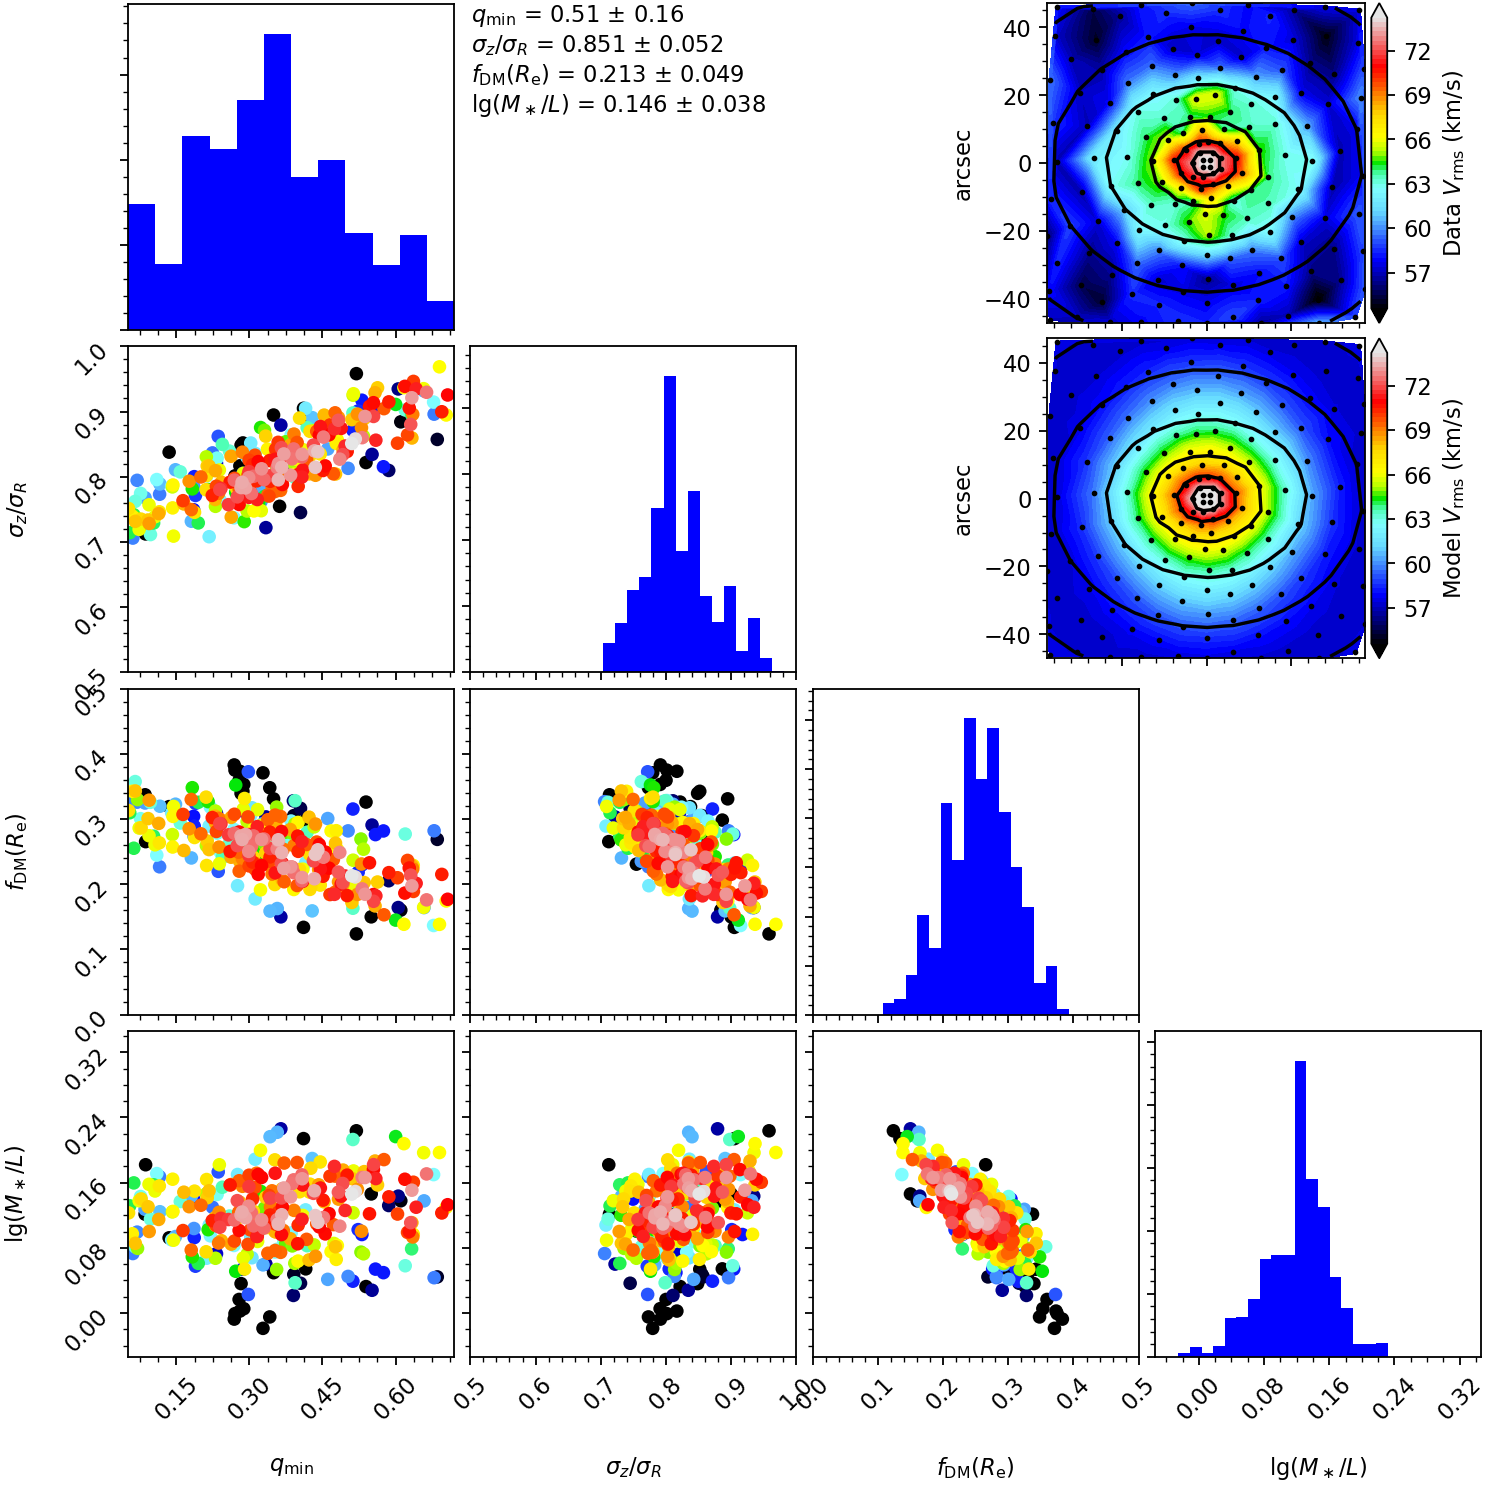

In [14]:
# Produce final corner plot without trial values and with best fitting JAM
plt.clf()
fig = corner_plot(pars, lnprob, labels=labels, extents=bounds)
fig.text(0.33, .99, txt.latex, ha='left', va='top')
jam_lnprob(bestfit)  # Compute model at best fit location

dx = 0.24
yfac = 0.87

# Data
fig.add_axes([0.69, 0.99 - dx*yfac, dx, dx*yfac])  # left, bottom, xsize, ysize
rms1 = rms.copy()
rms1[goodbins] = symmetrize_velfield(xbin[goodbins], ybin[goodbins], rms[goodbins])
vmin, vmax = np.percentile(rms1[goodbins], [0.5, 99.5])
plot_velfield(xbin, ybin, rms1, vmin=vmin, vmax=vmax, colorbar=True, 
              label=r"Data $V_{\rm rms}$ (km/s)", flux=jam_lnprob.out.flux)
plt.tick_params(labelbottom=False)
plt.ylabel('arcsec')

# Model
fig.add_axes([0.69, 0.98 - 2*dx*yfac, dx, dx*yfac])  # left, bottom, xsize, ysize
plot_velfield(xbin, ybin, jam_lnprob.out.model, vmin=vmin, vmax=vmax, colorbar=True, 
              label=r"Model $V_{\rm rms}$ (km/s)", flux=jam_lnprob.out.flux)
plt.tick_params(labelbottom=False)
plt.ylabel('arcsec');